## **Taller 2 - Fundamentos de Analítica de Datos**
### **Daniel Martínez Villegas & Luis Felipe Montenegro**

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
import shutil
import torchvision.ops as ops
import os.path as osp
import typing as ty
import cv2
from skimage import io, transform
from numpy.typing import NDArray


In [2]:
# I have defined a directory structure for the data. The data is stored in the following way: 
data_dir = 'data'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [3]:
train_info = pd.read_csv('train.csv')
test_info = pd.read_csv('test.csv')

X = train_info[['filename', 'xmin', 'ymin', 'xmax', 'ymax']]
y = train_info['class_id']

data = pd.concat([X, y], axis=1)	

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)
validation_data = pd.concat([X_val, y_val], axis=1)

In [5]:
# Using the train-test fot the training and validation data folders
def create_train_validation_img_folder(train_df, val_df):
    splits = {'train': train_df, 'validation': val_df}
    for split, df in splits.items():
        for i, row in df.iterrows():
            source_file = f'images/{row["filename"]}'
            destination_folder = f'data/{split}'
            os.makedirs(destination_folder, exist_ok=True)
            destination_file = os.path.join(destination_folder)
            shutil.copy(source_file, destination_file)

# Using the test data for the test folder
def create_test_img_folder(test_df):
	for i, row in test_df.iterrows():
		source_file = f'images/{row["filename"]}'
		destination_folder = 'data/test'
		os.makedirs(destination_folder, exist_ok=True)
		destination_file = os.path.join(destination_folder)
		shutil.copy(source_file, destination_file)

# Creating the folders
create_train_validation_img_folder(train_data, validation_data)
create_test_img_folder(test_info)

In [6]:
class BoundingBoxDataset(Dataset):
    def __init__(self, data, root_dir, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_name = os.path.join(self.root_dir, row['filename'])
        image = plt.imread(img_name)
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Extract bounding box coordinates
        bbox = torch.tensor([row['xmin'], row['ymin'], row['xmax'], row['ymax']])
        
        label = torch.tensor(row['class_id'] - 1)  # Subtract 1 to make labels 0-based

        return image, label, bbox


In [7]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop((255, 255), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

validation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((255, 255)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Load train and test data
train_dataset = BoundingBoxDataset(train_data, root_dir=train_dir, transform=train_transforms)
validation_dataset = BoundingBoxDataset(validation_data, root_dir=validation_dir, transform=validation_transforms)

# Data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


In [8]:
# Loss functions
classification_criterion = nn.CrossEntropyLoss()
regression_criterion = nn.SmoothL1Loss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## VGG16

In [11]:
class MultiTaskVGG16(nn.Module):
    def __init__(self, base_model):
        super(MultiTaskVGG16, self).__init__()
        
        # Base feature extractor
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.flatten = nn.Flatten()
        
        # Shared fully connected layers
        self.shared_fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Classification head
        self.classifier = nn.Linear(4096, 2)
        
        # Bounding box regression head
        self.regressor = nn.Linear(4096, 4) 

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.shared_fc(x)
        
        class_output = self.classifier(x)
        bbox_output = self.regressor(x)
        
        return class_output, bbox_output




## InceptionV3

In [30]:
class MultiTaskInceptionV3(nn.Module):
    def __init__(self):
        super(MultiTaskInceptionV3, self).__init__()
        
        # Load the Inception_v3 model
        base_model = models.inception_v3(pretrained=True, aux_logits=True)
        
        # Use the model's Conv2d layers up to the last pooling layer as the feature extractor
        self.features = nn.Sequential(
            base_model.Conv2d_1a_3x3,
            base_model.Conv2d_2a_3x3,
            base_model.Conv2d_2b_3x3,
            base_model.maxpool1,
            base_model.Conv2d_3b_1x1,
            base_model.Conv2d_4a_3x3,
            base_model.maxpool2,
            base_model.Mixed_5b,
            base_model.Mixed_5c,
            base_model.Mixed_5d,
            base_model.Mixed_6a,
            base_model.Mixed_6b,
            base_model.Mixed_6c,
            base_model.Mixed_6d,
            base_model.Mixed_6e,
            base_model.Mixed_7a,
            base_model.Mixed_7b,
            base_model.Mixed_7c,
        )
        
        # Average pooling and flatten
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        
        # Fully connected shared layers
        self.shared_fc = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Classification head
        self.classifier = nn.Linear(4096, 2)
        
        # Bounding box regression head
        self.regressor = nn.Linear(4096, 4)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.shared_fc(x)
        
        class_output = self.classifier(x)
        bbox_output = self.regressor(x)
        
        return class_output, bbox_output

## Custom train function using any given model

In [31]:
def train(model, train_loader, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels, bboxes in tqdm(train_loader):
        images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
        
        optimizer.zero_grad()
        class_outputs, bbox_outputs = model(images)
        
        # Compute losses
        class_loss = classification_criterion(class_outputs, labels)
        bbox_loss = regression_criterion(bbox_outputs, bboxes.float())
        loss = class_loss + bbox_loss  # Combine losses
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

## IoU Metric

In [32]:
def calculate_iou(pred_boxes, true_boxes):
    return ops.box_iou(pred_boxes, true_boxes).diag().mean().item()

## Evaluate

In [33]:
def evaluate(model, test_loader, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    iou_scores = []
    
    with torch.no_grad():
        for images, labels, bboxes in tqdm(test_loader):
            images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
            
            class_outputs, bbox_outputs = model(images)
            
            # Compute losses
            class_loss = classification_criterion(class_outputs, labels)
            bbox_loss = regression_criterion(bbox_outputs, bboxes.float())
            loss = class_loss + bbox_loss
            running_loss += loss.item() * images.size(0)
            
            # Store predictions and labels for accuracy calculation
            preds = class_outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Calculate IoU and append to list
            iou = calculate_iou(bbox_outputs, bboxes)
            iou_scores.append(iou)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)  # Classification accuracy
    average_iou = sum(iou_scores) / len(iou_scores)  # Average IoU across the dataset
    epoch_loss = running_loss / len(test_loader.dataset)
    
    return epoch_loss, accuracy, average_iou



## VGG16 trainning

In [34]:
base_model = models.vgg16(pretrained=True)

# Freeze the base model layers
for param in base_model.parameters():
    param.requires_grad = False

# Initialize model
model = MultiTaskVGG16(base_model).to(device)
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

/Users/danielmartinezvillegas/anaconda3/envs/tf-macos/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/danielmartinezvillegas/anaconda3/envs/tf-macos/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
def train_model(model, train_loader, validation_loader, optimizer, device, num_epochs=10):
    best_accuracy = 0.0
    best_IoU = 0.0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        train_loss = train(model, train_loader, optimizer, device)
        val_loss, val_accuracy, test_iou = evaluate(model, validation_loader, device)
        
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Test Average IoU: {test_iou:.4f}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_IoU = test_iou
            # torch.save(model.state_dict(), "best_model_full.pth")
            # print("Saved Best Model!")

In [36]:
train_model(model, train_loader, validation_loader, optimizer, device, num_epochs=1)

Epoch 1/1


100%|██████████| 6/6 [00:14<00:00,  2.45s/it]

Train Loss: 176.7252
Validation Loss: 122.9484
Validation Accuracy: 0.9789
Test Average IoU: 0.0235


## InceptioV3 trainning

In [38]:
model = MultiTaskInceptionV3().to(device)

# Freeze the base model layers
for param in model.features.parameters():
    param.requires_grad = False

# Optimizer (only fine-tuning the final layers)
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)


In [39]:
train_model(model, train_loader, validation_loader, optimizer, device, num_epochs=1)

Epoch 1/1


100%|██████████| 6/6 [00:09<00:00,  1.62s/it]

Train Loss: 222.5563
Validation Loss: 182.3556
Validation Accuracy: 0.5053
Test Average IoU: 0.0000


# Predict

In [ ]:
# Custom dataset for validation/test set without labels
class TestDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename = self.data.iloc[idx]['filename']
        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, filename  # Only return image and filename


In [17]:
# Define transformations
data_transforms = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Paths
csv_file = 'test.csv'
img_dir = 'images'

# Create the dataset and loader
test_dataset = TestDataset(csv_file, img_dir, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [20]:
# Inference and saving to CSV for unlabeled validation/test set
def predict_and_save_unlabeled(model, loader, device, output_file="test_predictions.csv"):
    model.eval()
    predictions = []
    seen_filenames = set()  # Track unique filenames to avoid duplicates
    
    with torch.no_grad():
        for images, filenames in loader:  # Accepts images and filenames only
            images = images.to(device)
            class_outputs, bbox_outputs = model(images)
            
            # Get predicted class (1-based indexing)
            class_preds = class_outputs.argmax(dim=1).cpu().numpy() + 1  
            # Get bounding box predictions
            bbox_preds = bbox_outputs.cpu().numpy()
            
            # Save predictions for each file
            for filename, class_id, bbox_pred in zip(filenames, class_preds, bbox_preds):
                # Only add unique filenames
                if filename not in seen_filenames:
                    predictions.append([filename, class_id, *bbox_pred])
                    seen_filenames.add(filename)  # Mark this filename as seen
    
    # Save predictions to CSV
    submission_df = pd.DataFrame(predictions, columns=[
        "filename", "pred_class_id", "pred_xmin", "pred_ymin", "pred_xmax", "pred_ymax"
    ])
    submission_df.to_csv(output_file, index=False)
    
    print(f"Saved predictions to {output_file}")

# Run the prediction and save function for validation/test data
# predict_and_save_unlabeled(model, test_loader, device, output_file="test_predictions_perfect.csv")


base_model = models.vgg16(pretrained=True)
model = MultiTaskVGG16(base_model).to(device)
model.load_state_dict(torch.load("best_model_full.pth"))
# Run the prediction and save function
predict_and_save_unlabeled(model, test_loader, device, output_file="hola.csv")



/var/folders/b9/t4lk8c451h5dmb3m5570wjvc0000gn/T/ipykernel_68097/2734506764.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model

Saved predictions to hola.csv


# Show results

In [23]:
DATA_DIR = ''
hw_real=640
h, w, c = 255, 255, 3 # The heigh, width and number of channels of each image

In [24]:
df_predicted = pd.read_csv("hola.csv")
df_predicted['pred_class_id'] = np.where(df_predicted['pred_class_id']==2,1,0)

obj2id = {
    "penguin": 0, 
    "turtle": 1
}

id2obj = {
    0: "penguin",
    1: "turtle"
}

df_predicted['pred_xmax'] = df_predicted['pred_xmin'] + df_predicted['pred_xmax']
df_predicted['pred_ymax'] = df_predicted['pred_ymin'] + df_predicted['pred_ymax']


df_predicted["class"] = df_predicted["pred_class_id"].map(id2obj)


In [25]:
df_predicted[["pred_xmin", "pred_ymin", "pred_xmax", "pred_ymax"]] /= hw_real

In [26]:
transform_func_inp_signature = ty.Dict[str, NDArray[np.float_]]
transform_func_signature = ty.Callable[
    [transform_func_inp_signature],
    transform_func_inp_signature
]

class ImageDataset(Dataset):
    """
    Location image dataset
    """
    def __init__(
        self, 
        df: pd.DataFrame, 
        root_dir: str, 
        labeled: bool = True,
        transform: ty.Optional[ty.List[transform_func_signature]] = None,
        output_size: ty.Optional[tuple] = None  # Añadir parámetro para tamaño de salida
    ) -> None:
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.labeled = labeled
        self.output_size = output_size  # Almacenar el tamaño de salida
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx: int) -> transform_func_signature: 
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Read image
        img_name = os.path.join(self.root_dir, self.df.filename.iloc[idx])
        image = io.imread(img_name)
        
        #print(f"Dimensiones originales de la imagen: {image.shape}")  # Agregar para depuración

        if image.ndim == 2:  # Si la imagen está en escala de grises
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)  # Convertir a RGB
        elif image.shape[2] == 4:  # Si la imagen es RGBA
            image = image[:, :, :3] 
            
        # Redimensionar la imagen si se especifica un tamaño de salida
        if self.output_size:
            image = cv2.resize(image, self.output_size)
        
        sample = {'image': image}
        
        if self.labeled:
            # print(self.df.pred_class_id)
            img_class = self.df.pred_class_id.iloc[idx]
            img_bbox = self.df.iloc[idx, 2:6]
            img_bbox = np.array([img_bbox]).astype('float')
            img_class = np.array([img_class]).astype('int')
            sample.update({'bbox': img_bbox, 'class_id': img_class})
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [27]:
def draw_bbox(img, bbox, color):
    xmin, ymin, xmax, ymax = bbox
    img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, 2)
    return img

def normalize_bbox(bbox, factor : int = 255):
    return list(map(lambda x: int(x * factor), bbox))

def draw_bboxes(imgs, bboxes, colors):
    for i, (img, bbox, color) in enumerate(zip(imgs, bboxes, colors)):
        imgs[i] = draw_bbox(img, bbox, color)
    return imgs

def draw_classes(imgs, classes, colors, origin, offset: int = 5, prefix: str =''):
    for i, (img, class_id, color) in enumerate(zip(imgs, classes, colors)): 
        if type(c)==list:
            name_class_=id2obj[classes[i]]
        else:
            name_class_=id2obj[classes[i][0]]
        imgs[i] = cv2.putText(
            img, f'{prefix}{name_class_}', #class_id.squeeze()
            origin, cv2.FONT_HERSHEY_SIMPLEX, 
            0.4, color, 1, cv2.LINE_AA
        )
    return imgs

def draw_predictions(imgs, classes, bboxes, colors, origin):
    assert all(len(x) > 0 for x in [imgs, classes, bboxes, colors])
    if len(colors) == 1:
        colors = [colors[0] for _ in imgs]
    imgs = draw_bboxes(imgs, bboxes, colors)
    imgs = draw_classes(imgs, classes, colors, origin)
    return imgs

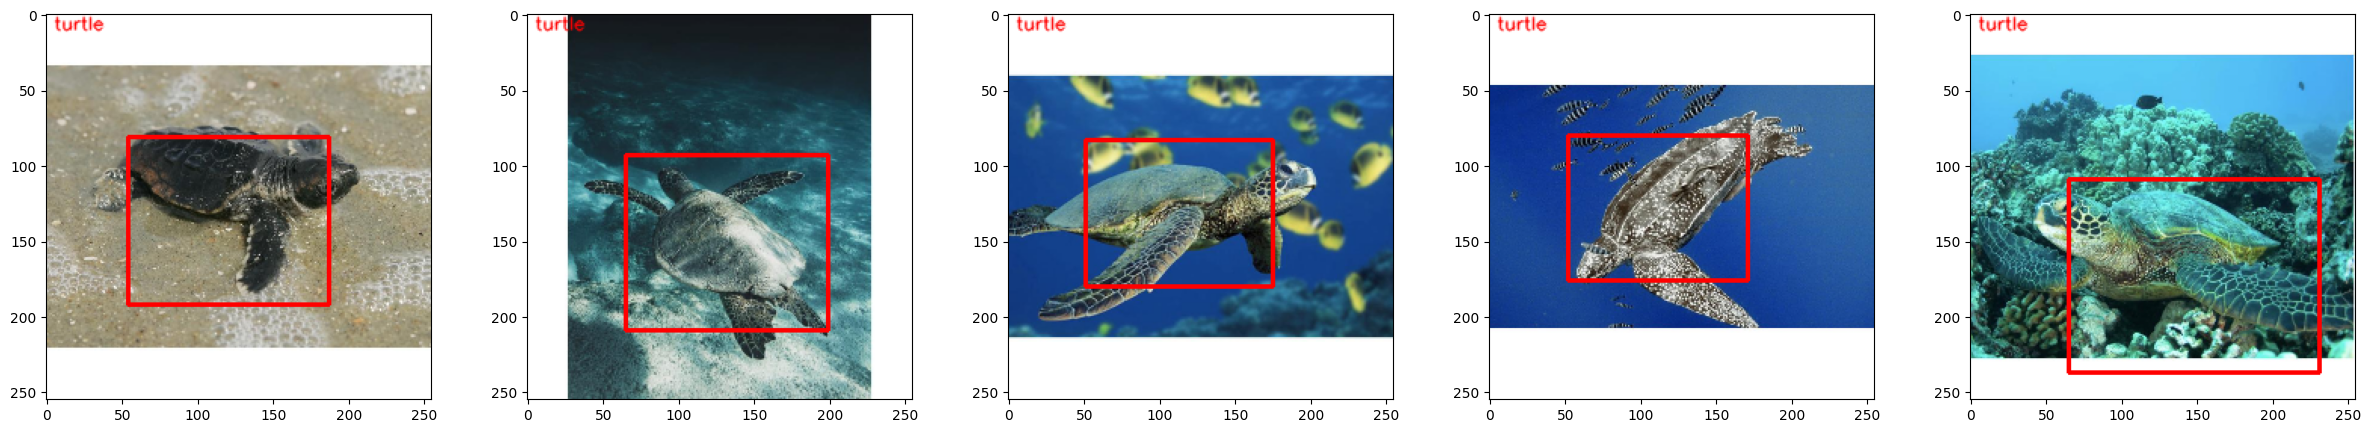

In [38]:
import random as rand
train_root_dir = osp.join(DATA_DIR, "images")

train_ds = ImageDataset(df_predicted, root_dir=train_root_dir,output_size=(255,255))

num_imgs = 5
start_idx = rand.randint(0, len(train_ds) - num_imgs)



samples = [train_ds[i] for i in range(start_idx, start_idx + num_imgs)]


imgs = [s['image'] for s in samples]
bboxes = [normalize_bbox(s['bbox'].squeeze()) for s in samples]


classes = [s['class_id'] for s in samples]
imgs = draw_predictions(imgs, classes, bboxes, [(255, 0, 0)], (5, 10))#(150, 10)
classes

fig = plt.figure(figsize=(30, num_imgs))

for i, img in enumerate(imgs):
    fig.add_subplot(1, num_imgs, i+1)
    plt.imshow(img)

plt.show()